In [4]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
from sklearn.neighbors import KNeighborsClassifier

In [12]:
# To use 한글 font in graphs
plt.rc('font', family='NanumBarunGothic')
plt.rcParams['axes.unicode_minus']=False

ds_hmeq = pd.read_csv("./csvfiles/HMEQ.csv")

ds_hmeq.isnull().sum()

ds_hmeq["JOB"].fillna("Other", inplace = True)
ds_hmeq.fillna(ds_hmeq.mean(), inplace = True)

ds_hmeq_dummy = pd.get_dummies(ds_hmeq)
ds_hmeq_dummy.head()

np.random.seed(seed = 1234)
msk = np.random.rand(ds_hmeq_dummy.shape[0]) < 0.7
ds_hmeq_train = ds_hmeq_dummy[msk]
ds_hmeq_test = ds_hmeq_dummy[~msk]

ds_hmeq_train_y = ds_hmeq_train["BAD"]
ds_hmeq_train_x = ds_hmeq_train.drop("BAD", axis = 1)
ds_hmeq_test_y = ds_hmeq_test["BAD"]
ds_hmeq_test_x = ds_hmeq_test.drop("BAD", axis = 1)

print("train data X size:", ds_hmeq_train_x.shape)
print("train data y size:", ds_hmeq_train_y.shape)
print("test data X size:", ds_hmeq_test_x.shape)
print("test data y size:", ds_hmeq_test_y.shape)



train data X size: (2604, 18)
train data y size: (2604,)
test data X size: (1144, 18)
test data y size: (1144,)


In [13]:
knn_uncustomized = KNeighborsClassifier()

In [16]:
knn_uncustomized.fit(ds_hmeq_train_x,ds_hmeq_train_y)

y_pred = knn_uncustomized.predict(ds_hmeq_test_x)
print("predict test set: {}".format(y_pred.tolist()[:10]))
print("test set label: {}".format(ds_hmeq_test_y.tolist()[:10]))
print("Accuracy on test set : {:.3f}".format(knn_uncustomized.score(ds_hmeq_test_x,ds_hmeq_test_y)))

predict test set: [0, 0, 0, 0, 0, 0, 1, 0, 0, 0]
test set label: [1, 0, 1, 1, 0, 0, 1, 0, 0, 0]
Accuracy on test set : 0.909


In [21]:
max_n_neighbors = 10
para_n_neighbors = [i+1 for i in range(max_n_neighbors)]
#train 및 test정확도 결과 저장용
train_accuracy = []
test_accuracy = []
for i in para_n_neighbors:
    clf = KNeighborsClassifier(n_neighbors=i)
    clf.fit(ds_hmeq_train_x, ds_hmeq_train_y)
    train_accuracy.append(clf.score(ds_hmeq_train_x, ds_hmeq_train_y))
    test_accuracy.append(clf.score(ds_hmeq_test_x, ds_hmeq_test_y))
    
#저장된 모델의 criterion 및 train/test 데이터 분류 정확도 테이블 생성

ds_neighbors = pd.DataFrame()
ds_neighbors["Neighbors"] = para_n_neighbors
ds_neighbors["TrainAccuracy"] = train_accuracy
ds_neighbors["TestAccuracy"] = test_accuracy
ds_neighbors.round(3)


,Neighbors,TrainAccuracy,TestAccuracy
0,1,1.000,0.876
1,2,0.929,0.911
2,3,0.932,0.907
3,4,0.915,0.909
4,5,0.916,0.909
5,6,0.911,0.910
6,7,0.911,0.910
7,8,0.910,0.910
8,9,0.909,0.911
9,10,0.908,0.910


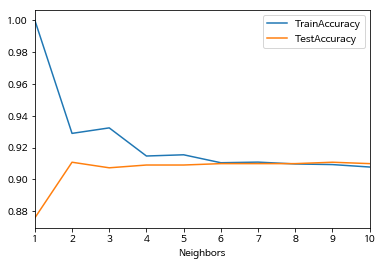

In [22]:
ds_neighbors.set_index("Neighbors").plot()

In [27]:
# 가중치별 이웃 수 증가에 따른 정확도 변화
max_n_neighbors = 10
para_n_neighbors = [i+1 for i in range(max_n_neighbors)] * 2
# 가중치 ( uniform, distance)
para_weights = ["uniform"] * max_n_neighbors + ["distance"] * max_n_neighbors
#train 및 test정확도 결과 저장용
train_accuracy = []
test_accuracy = []
for (n_neighbors, weights) in zip(para_n_neighbors, para_weights):
    clf = KNeighborsClassifier(n_neighbors=n_neighbors, weights=weights)
    clf.fit(ds_hmeq_train_x, ds_hmeq_train_y)
    train_accuracy.append(clf.score(ds_hmeq_train_x, ds_hmeq_train_y))
    test_accuracy.append(clf.score(ds_hmeq_test_x, ds_hmeq_test_y))
    
#저장된 모델의 criterion 및 train/test 데이터 분류 정확도 테이블 생성

ds_neighbors2 = pd.DataFrame()
ds_neighbors2["Neighbors"] = para_n_neighbors
ds_neighbors2["Weights"] = para_weights
ds_neighbors2["TrainAccuracy"] = train_accuracy
ds_neighbors2["TestAccuracy"] = test_accuracy
ds_neighbors2.round(3)


,Neighbors,Weights,TrainAccuracy,TestAccuracy
0,1,uniform,1.000,0.876
1,2,uniform,0.929,0.911
2,3,uniform,0.932,0.907
3,4,uniform,0.915,0.909
4,5,uniform,0.916,0.909
5,6,uniform,0.911,0.910
6,7,uniform,0.911,0.910
7,8,uniform,0.910,0.910
8,9,uniform,0.909,0.911
9,10,uniform,0.908,0.910


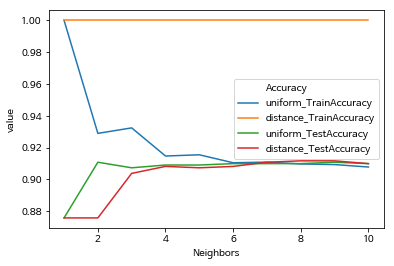

In [29]:
ds_neighbors_weight_melt = pd.melt(ds_neighbors2, id_vars=["Neighbors", "Weights"])
ds_neighbors_weight_melt['Accuracy'] = ds_neighbors_weight_melt["Weights"] + "_" + ds_neighbors_weight_melt["variable"]

ax = sns.lineplot(x="Neighbors", y="value", hue="Accuracy", data=ds_neighbors_weight_melt)

In [33]:
# 알고리즘별 이웃 수 증가에 따른 정확도 변화
max_n_neighbors = 10
para_n_neighbors = [i+1 for i in range(max_n_neighbors)] * 3
# 알고리즘(ball_tree, kd_tree, brute
para_algorithm = ["ball_tree"] * max_n_neighbors + ["kd_tree"] * max_n_neighbors + ['brute'] * max_n_neighbors

#train 및 test정확도 결과 저장용
train_accuracy = []
test_accuracy = []
for (n_neighbors, algorithm) in zip(para_n_neighbors, para_algorithm):
    clf = KNeighborsClassifier(n_neighbors=n_neighbors, weights='uniform', algorithm=algorithm)
    clf.fit(ds_hmeq_train_x, ds_hmeq_train_y)
    train_accuracy.append(clf.score(ds_hmeq_train_x, ds_hmeq_train_y))
    test_accuracy.append(clf.score(ds_hmeq_test_x, ds_hmeq_test_y))
    
#저장된 모델의 criterion 및 train/test 데이터 분류 정확도 테이블 생성

ds_neighbors3 = pd.DataFrame()
ds_neighbors3["Neighbors"] = para_n_neighbors
ds_neighbors3["Algorithm"] = para_algorithm
ds_neighbors3["TrainAccuracy"] = train_accuracy
ds_neighbors3["TestAccuracy"] = test_accuracy
ds_neighbors3.round(3).head()


,Neighbors,Algorithm,TrainAccuracy,TestAccuracy
0,1,ball_tree,1.000,0.876
1,2,ball_tree,0.929,0.911
2,3,ball_tree,0.932,0.907
3,4,ball_tree,0.915,0.909
4,5,ball_tree,0.916,0.909


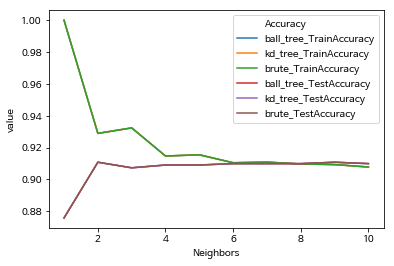

In [37]:
ds_neighbors_algorithm_melt = pd.melt(ds_neighbors3, id_vars=["Neighbors", "Algorithm"])
ds_neighbors_algorithm_melt['Accuracy'] = ds_neighbors_algorithm_melt["Algorithm"] + "_" + ds_neighbors_algorithm_melt["variable"]

ax = sns.lineplot(x="Neighbors", y="value", hue="Accuracy", data=ds_neighbors_algorithm_melt)

In [45]:
# 거리 계산 방법별 이웃 수 증가에 따른 정확도 변화
max_n_neighbors = 10
para_n_neighbors = [i+1 for i in range(max_n_neighbors)] * 3
# 알고리즘(ball_tree, kd_tree, brute
para_metric = ["minkowski"] * max_n_neighbors + ["euclidean"] * max_n_neighbors + ['manhattan'] * max_n_neighbors

#train 및 test정확도 결과 저장용
train_accuracy = []
test_accuracy = []
for (n_neighbors, metric) in zip(para_n_neighbors, para_metric):
    clf = KNeighborsClassifier(n_neighbors=n_neighbors, weights='uniform', algorithm='ball_tree', metric=metric)
    clf.fit(ds_hmeq_train_x, ds_hmeq_train_y)
    train_accuracy.append(clf.score(ds_hmeq_train_x, ds_hmeq_train_y))
    test_accuracy.append(clf.score(ds_hmeq_test_x, ds_hmeq_test_y))
    
#저장된 모델의 criterion 및 train/test 데이터 분류 정확도 테이블 생성

ds_neighbors4 = pd.DataFrame()
ds_neighbors4["Neighbors"] = para_n_neighbors
ds_neighbors4["Metric"] = para_algorithm
ds_neighbors4["TrainAccuracy"] = train_accuracy
ds_neighbors4["TestAccuracy"] = test_accuracy
ds_neighbors4.round(3).head()


,Neighbors,Metric,TrainAccuracy,TestAccuracy
0,1,ball_tree,1.000,0.876
1,2,ball_tree,0.929,0.911
2,3,ball_tree,0.932,0.907
3,4,ball_tree,0.915,0.909
4,5,ball_tree,0.916,0.909


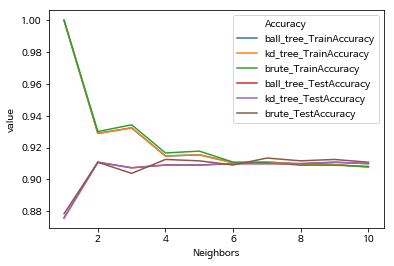

In [46]:
ds_neighbors_metric_melt = pd.melt(ds_neighbors4, id_vars=["Neighbors", "Metric"])
ds_neighbors_metric_melt['Accuracy'] = ds_neighbors_metric_melt["Metric"] + "_" + ds_neighbors_metric_melt["variable"]

ax = sns.lineplot(x="Neighbors", y="value", hue="Accuracy", data=ds_neighbors_metric_melt)